In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans as kmeans
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr as pears
import seaborn as sns
import math
import os
import tensorflow as tf
from tensorflow import keras
from keras.utils import to_categorical

excelpath = 'excel_gaming_data'
ddict = {} # Created A dataframe dictionary to modify each dictionary iteratively
for filename in os.listdir(excelpath): # Iterates through each excel file
    f = os.path.join(excelpath, filename)
    # checking if it is a file
    if os.path.isfile(f) & ~filename.startswith('.'):
        ddict[filename[-6:-4]] = pd.read_excel(excelpath + '/' + filename) # sets the value of each dictionary
        
        for idx, val in enumerate(ddict[filename[-6:-4]].iloc[0,:]): # Iterates through each column of the excel spread sheet in question
            if idx > 1:
                if idx > 7:
                    ddict[filename[-6:-4]].columns.values[idx] = ddict[filename[-6:-4]].iloc[0,idx] + ' 20' + str(filename[-6:-4]) # Changes the column name using the next year and the month. The next year is used if past December, which corresponds to an index of 7, ad
                else:
                    ddict[filename[-6:-4]].columns.values[idx] = ddict[filename[-6:-4]].iloc[0,idx] + ' 20' + str(filename[-9:-7]) # Changes the column name using the first year specified and the month
        if filename[-6:-4] != '11': # Removes the first 2 columns of the excel spread sheet, except if it is the starting year spread sheet
            ddict[filename[-6:-4]] = ddict[filename[-6:-4]].drop(columns=ddict[filename[-6:-4]].columns[0])
            ddict[filename[-6:-4]] = ddict[filename[-6:-4]].drop(columns=ddict[filename[-6:-4]].columns[0])
            
gamedf = ddict['11'] # initializes the dataframe for our game data
for ind in range(12,21): # Concatenates all dictionary values into one pandas dataframe
    gamedf = pd.concat([gamedf,ddict[str(ind)]],axis=1)

# Changed some column names:
gamedf.columns.values[0] = 'Location' 
gamedf.columns.values[1] = 'Attributes'
gamedf = gamedf.drop(0) # Removes the first row 
gamedf = gamedf.iloc[0:429,:] # We had extra noisy data, which I just removed, since it did not correspond to a date.
# I don't know why this is, hopefully it didn't correspond to other data, but I didn't see any missing data.
gamedf_T=gamedf.T
gamedf_T.columns = gamedf_T.iloc[1]
gamedf_T=gamedf_T.drop(gamedf_T.index[[1]])


colval = gamedf_T.columns[0] # The first column header device

# Renamed the column headers so each attribute is unique to a device. This will allow us to reference these headers.
for ind in range(1,len(gamedf_T.columns)):
    if pd.isna(gamedf_T.columns[ind - 1]):
        colval = gamedf_T.columns[ind]

    if (not pd.isna(gamedf_T.columns[ind - 1])) and (not pd.isna(gamedf_T.columns[ind])):
        gamedf_T.columns.values[ind] = str(colval) + ' ' + str(gamedf_T.columns[ind])

for ind in range(1,len(gamedf_T.columns)):
    if pd.isna(gamedf_T.columns[ind]):
        gamedf_T.columns.values[ind] = 'trash'

gamedf_T.drop(['trash'], axis = 1, inplace = True)

# Filled in missing values using the mean of the corresponding column
for col in gamedf_T.columns:
    avg = gamedf_T[col].mean()
    gamedf_T[col].fillna(avg, inplace = True)

filt = (gamedf_T == 'Statewide').any()
state = gamedf_T.loc[: , filt].drop(['Location'])

filt = (gamedf_T == 'Cripple Creek').any()
cripple = gamedf_T.loc[: , filt].drop(['Location'])

filt = (gamedf_T == 'Black Hawk').any()
black = gamedf_T.loc[: , filt].drop(['Location'])

filt = (gamedf_T == 'Central City').any()
central = gamedf_T.loc[: , filt].drop(['Location'])

gamedf_T.drop(['Location'], inplace = True)
gamedf_T.reset_index(inplace = True)
gamedf_T[['month','year']] = gamedf_T.iloc[:,0].str.split(expand=True)

Winter = [x.upper() for x in ['December', 'January', 'February']]
Spring = [x.upper() for x in ['March', 'April', 'May']]
Summer = [x.upper() for x in ['June', 'July', 'August']]
Autumn = [x.upper() for x in ['September', 'October', 'November']]

winterfilt = (gamedf_T['month'].isin(Winter))
springfilt = (gamedf_T['month'].isin(Spring))
summerfilt = (gamedf_T['month'].isin(Summer))
autumnfilt = (gamedf_T['month'].isin(Autumn))

gamedf_T['season'] = np.nan

gamedf_T.loc[winterfilt,'season'] = 'WINTER'
gamedf_T.loc[springfilt,'season'] = 'SPRING'
gamedf_T.loc[summerfilt,'season'] = 'SUMMER'
gamedf_T.loc[autumnfilt,'season'] = 'AUTUMN'

print(gamedf_T.head(20))
#resets the index so we can work this the month year column
state.reset_index(inplace=True)
state[['month','year']] = state.iloc[:,0].str.split(expand=True)
#state = state.set_index(['year', 'month'])

cripple.reset_index(inplace=True)
cripple[['month','year']] = cripple.iloc[:,0].str.split(expand=True)

black.reset_index(inplace=True)
black[['month','year']] = black.iloc[:,0].str.split(expand=True)

central.reset_index(inplace=True)
central[['month','year']] = central.iloc[:,0].str.split(expand=True)
print(central)

#create a df containing only the yearly total values
monchoose = ['JULY', 'AUGUST', 'SEPTEMBER', 'OCTOBER', 'NOVEMBER', 'DECEMBER', 'JANUARY', 'FEBRUARY', 'MARCH', 'APRIL', 'MAY', 'JUNE']

state_totals= state.loc[state['month'].isin(monchoose)]

cripple_totals= cripple.loc[cripple['month'].isin(monchoose)]

black_totals= black.loc[black['month'].isin(monchoose)]

central_totals= central.loc[central['month'].isin(monchoose)]
gamedf_T.to_csv('gamedf_T.csv')
print(state_totals.head(20))

/tmp/ipykernel_179/998184413.py:66: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  avg = gamedf_T[col].mean()


Attributes           index Slots Total Slots Total Coins In Slots Total AGP  \
0                JULY 2010       15224         924881940.34     63485300.52   
1              AUGUST 2010       15182         900224418.95      60548129.6   
2           SEPTEMBER 2010       15189         859887596.89     59638919.56   
3             OCTOBER 2010       15067         859014005.02     58207468.91   
4            NOVEMBER 2010       14572         745499907.07     50949581.25   
5            DECEMBER 2010       14194         740211154.54      51507997.2   
6             JANUARY 2011       14367         781224517.61     53065324.29   
7            FEBRUARY 2011       14303         738530651.44     51589059.54   
8               MARCH 2011       14081         851830451.35     59112001.56   
9               APRIL 2011       14071         826837715.67     57182308.32   
10                MAY 2011       14082         848486244.76     58930584.95   
11               JUNE 2011       14116         78768

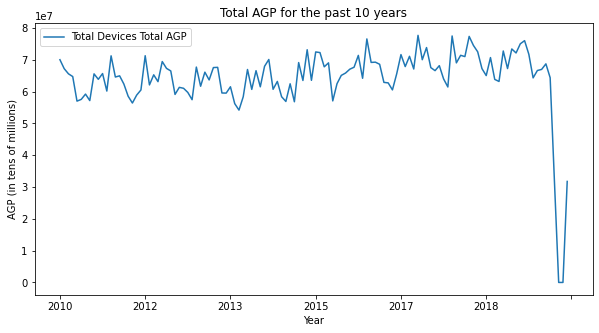

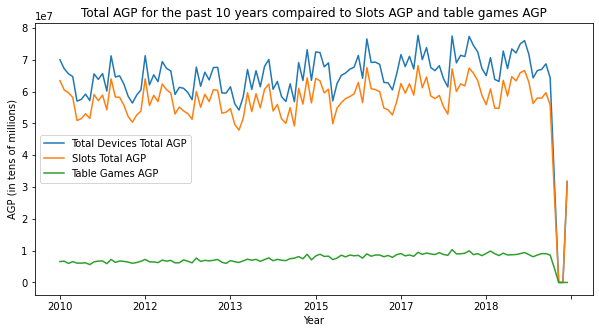

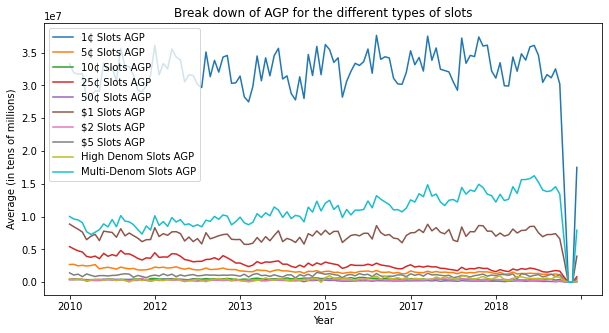

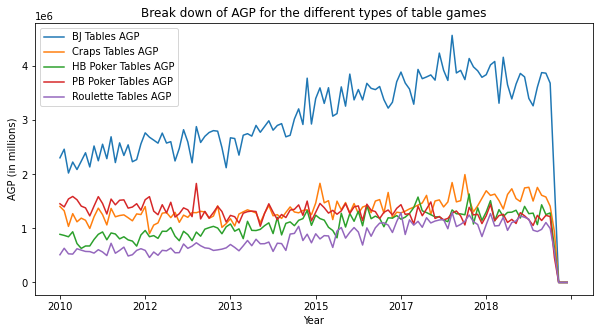

In [42]:
#plot 1
ax = plt.gca()

state_totals.plot(kind='line',x='year',y='Total Devices Total AGP',ax=ax)

plt.title("Total AGP for the past 10 years")
plt.xlabel("Year")
plt.ylabel("AGP (in tens of millions)")
plt.show()


#plot 2
ax = plt.gca()

state_totals.plot(kind='line',x='year',y='Total Devices Total AGP',ax=ax)
state_totals.plot(kind='line',x='year',y='Slots Total AGP',ax=ax)
state_totals.plot(kind='line',x='year',y='Table Games AGP',ax=ax)



plt.title("Total AGP for the past 10 years compaired to Slots AGP and table games AGP")
plt.xlabel("Year")
plt.ylabel("AGP (in tens of millions)")
plt.show()


#plot 3
ax = plt.gca()

state_totals.plot(kind='line',x='year',y='1¢ Slots AGP',ax=ax)
state_totals.plot(kind='line',x='year',y='5¢ Slots AGP',ax=ax)
state_totals.plot(kind='line',x='year',y='10¢ Slots AGP',ax=ax)
state_totals.plot(kind='line',x='year',y='25¢ Slots AGP',ax=ax)
state_totals.plot(kind='line',x='year',y='50¢ Slots AGP',ax=ax)
state_totals.plot(kind='line',x='year',y='$1 Slots AGP',ax=ax)
state_totals.plot(kind='line',x='year',y='$2 Slots AGP',ax=ax)
state_totals.plot(kind='line',x='year',y='$5 Slots AGP',ax=ax)
state_totals.plot(kind='line',x='year',y='High Denom Slots AGP',ax=ax)
state_totals.plot(kind='line',x='year',y='Multi-Denom Slots AGP',ax=ax)
#state.plot(kind='line',x='name',y='num_pets', color='red', ax=ax)

plt.title("Break down of AGP for the different types of slots")
plt.xlabel("Year")
plt.ylabel("Average (in tens of millions)")
plt.show()

#plot 4
ax = plt.gca()

state_totals.plot(kind='line',x='year',y='BJ Tables AGP',ax=ax)
state_totals.plot(kind='line',x='year',y='Craps Tables AGP',ax=ax)
state_totals.plot(kind='line',x='year',y='HB Poker Tables AGP',ax=ax)
state_totals.plot(kind='line',x='year',y='PB Poker Tables AGP',ax=ax)
state_totals.plot(kind='line',x='year',y='Roulette Tables AGP',ax=ax)
#state.plot(kind='line',x='name',y='num_pets', color='red', ax=ax)

plt.title("Break down of AGP for the different types of table games")
plt.xlabel("Year")
plt.ylabel("AGP (in millions)")
plt.show()


state_totals.to_csv('state_totals.csv')
colors = ['r','g','b']
#plt.scatter(state.iloc[:,0],np.zeros(len(state.iloc[:,0])), color='r')
#plt.scatter(cripple.iloc[:,0],np.zeros(len(cripple.iloc[:,0])), color='g')
#plt.scatter(black.iloc[:,0],np.zeros(len(black.iloc[:,0])), color='b')

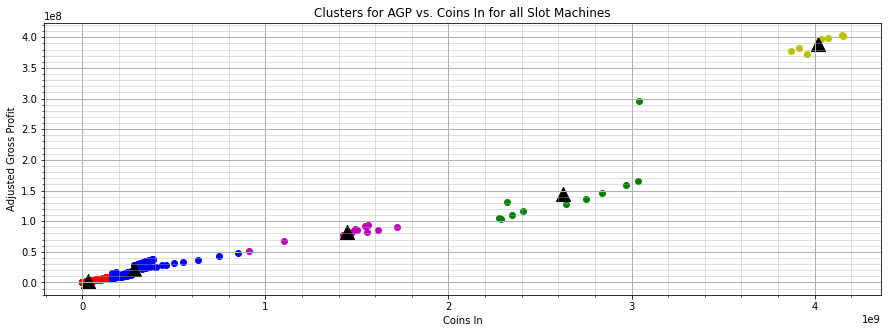

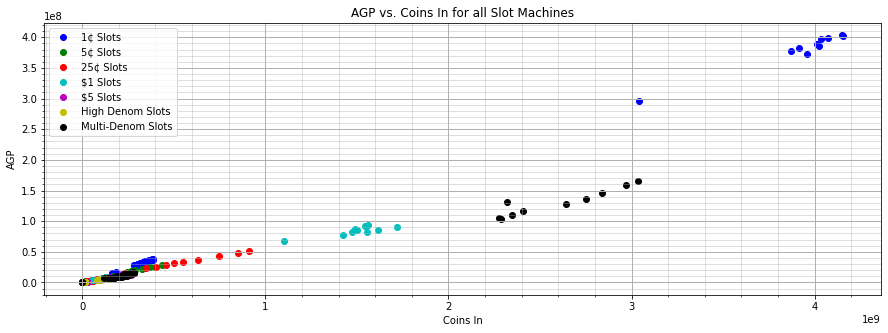

In [3]:
allsltagp = pd.concat([state.loc[:,'1¢ Slots AGP'],state.loc[:,'5¢ Slots AGP'],state.loc[:,'10¢ Slots AGP'],state.loc[:,'25¢ Slots AGP'],state.loc[:,'50¢ Slots AGP'],state.loc[:,'$1 Slots AGP'],state.loc[:,'$2 Slots AGP'],state.loc[:,'$5 Slots AGP'],state.loc[:,'High Denom Slots AGP'],state.loc[:,'Multi-Denom Slots AGP']])
allsltcoin = pd.concat([state.loc[:,'1¢ Slots Coins In'],state.loc[:,'5¢ Slots Coins In'],state.loc[:,'10¢ Slots Coins In'],state.loc[:,'25¢ Slots Coins In'],state.loc[:,'50¢ Slots Coins In'],state.loc[:,'$1 Slots Coins In'],state.loc[:,'$2 Slots Coins In'],state.loc[:,'$5 Slots Coins In'],state.loc[:,'High Denom Slots Coins In'],state.loc[:,'Multi-Denom Slots Coins In']])
plt.rcParams['figure.figsize'] = [15,5]
allsltagp = allsltagp.to_numpy()
allsltcoin = allsltcoin.to_numpy()

'''
plt.scatter(state.loc[:,'Slots Total Coins In'],state.loc[:,'Slots Total AGP'],color='r')
plt.scatter(cripple.loc[:,'Slots Total Coins In'],cripple.loc[:,'Slots Total AGP'],color='g')
plt.scatter(black.loc[:,'Slots Total Coins In'],black.loc[:,'Slots Total AGP'],color='b')
plt.scatter(central.loc[:,'Slots Total Coins In'],central.loc[:,'Slots Total AGP'],color='y')
'''

points = np.vstack((allsltcoin,allsltagp)).T
kmeansmodel = kmeans(n_clusters=5)
values = kmeansmodel.fit_predict(points)
centind0 = np.where(values[:] == 0)[0]
centind1 = np.where(values[:] == 1)[0]
centind2 = np.where(values[:] == 2)[0]
centind3 = np.where(values[:] == 3)[0]
centind4 = np.where(values[:] == 4)[0]
centroids = kmeansmodel.cluster_centers_

plt.figure(1)
plt.minorticks_on()
plt.grid(which='minor', alpha=0.5)
plt.grid(which='major', linewidth=1)

plt.scatter(allsltcoin[centind0],allsltagp[centind0],color='r')
plt.scatter(allsltcoin[centind1],allsltagp[centind1],color='g')
plt.scatter(allsltcoin[centind2],allsltagp[centind2],color='b')
plt.scatter(allsltcoin[centind3],allsltagp[centind3],color='m')
plt.scatter(allsltcoin[centind4],allsltagp[centind4],color='y')
plt.scatter(centroids[:,0],centroids[:,1],color='k', marker='^', s = 200)
plt.xlabel('Coins In')
plt.ylabel('Adjusted Gross Profit')
plt.title('Clusters for AGP vs. Coins In for all Slot Machines')
plt.savefig('slots-clusters.png')

plt.figure(2)
plt.minorticks_on()
plt.grid(which='minor', alpha=0.5)
plt.grid(which='major', linewidth=1)
plt.scatter(state.loc[:,'1¢ Slots Coins In'],state.loc[:,'1¢ Slots AGP'],color='b',label='1¢ Slots')
plt.scatter(state.loc[:,'5¢ Slots Coins In'],state.loc[:,'5¢ Slots AGP'],color='g',label='5¢ Slots')
plt.scatter(state.loc[:,'25¢ Slots Coins In'],state.loc[:,'25¢ Slots AGP'],color='r',label='25¢ Slots')
plt.scatter(state.loc[:,'$1 Slots Coins In'],state.loc[:,'$1 Slots AGP'],color='c',label='$1 Slots')
plt.scatter(state.loc[:,'$5 Slots Coins In'],state.loc[:,'$5 Slots AGP'],color='m',label='$5 Slots')
plt.scatter(state.loc[:,'High Denom Slots Coins In'],state.loc[:,'High Denom Slots AGP'],color='y',label='High Denom Slots')
plt.scatter(state.loc[:,'Multi-Denom Slots Coins In'],state.loc[:,'Multi-Denom Slots AGP'],color='k',label='Multi-Denom Slots')
plt.xlabel('Coins In')
plt.ylabel('AGP')
plt.title('AGP vs. Coins In for all Slot Machines')
plt.legend()

plt.savefig('slots-coins_in_vs_agp.png')

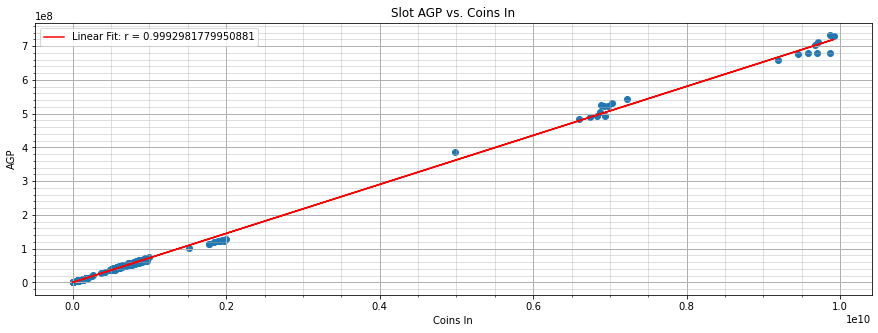

In [4]:
slotcoin = pd.concat([state.loc[:,'Slots Total Coins In'],cripple.loc[:,'Slots Total Coins In'],black.loc[:,'Slots Total Coins In'],central.loc[:,'Slots Total Coins In']],axis=0)
slotagp = pd.concat([state.loc[:,'Slots Total AGP'],cripple.loc[:,'Slots Total AGP'],black.loc[:,'Slots Total AGP'],central.loc[:,'Slots Total AGP']],axis=0)
slotagp = slotagp.to_numpy()
slotcoin = slotcoin.to_numpy()

xdata = slotcoin.reshape(-1,1)
ydata = slotagp.reshape(-1,1)
linreg = LinearRegression()
linreg.fit(xdata, ydata)
ydata_pred = linreg.predict(xdata)
corr = pears(xdata.flatten(),ydata)[0][0]

plt.figure(1)
plt.minorticks_on()
plt.grid(which='minor', alpha=0.5)
plt.grid(which='major', linewidth=1)
plt.plot(xdata,ydata_pred,'r')
plt.scatter(slotcoin,slotagp)
plt.title('Slot AGP vs. Coins In')
plt.xlabel('Coins In')
plt.ylabel('AGP')
plt.legend(['Linear Fit: r = ' + str(corr)], loc='upper left')
plt.rcParams['figure.figsize'] = [10,5]
plt.savefig('cluster-linear_regression.png')

Attributes           index Slots Total Slots Total Coins In Slots Total AGP  \
0                JULY 2010       15224         924881940.34     63485300.52   
1              AUGUST 2010       15182         900224418.95      60548129.6   
2           SEPTEMBER 2010       15189         859887596.89     59638919.56   
3             OCTOBER 2010       15067         859014005.02     58207468.91   
4            NOVEMBER 2010       14572         745499907.07     50949581.25   
5            DECEMBER 2010       14194         740211154.54      51507997.2   
6             JANUARY 2011       14367         781224517.61     53065324.29   
7            FEBRUARY 2011       14303         738530651.44     51589059.54   
8               MARCH 2011       14081         851830451.35     59112001.56   
9               APRIL 2011       14071         826837715.67     57182308.32   
10                MAY 2011       14082         848486244.76     58930584.95   
11               JUNE 2011       14116         78768

/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value


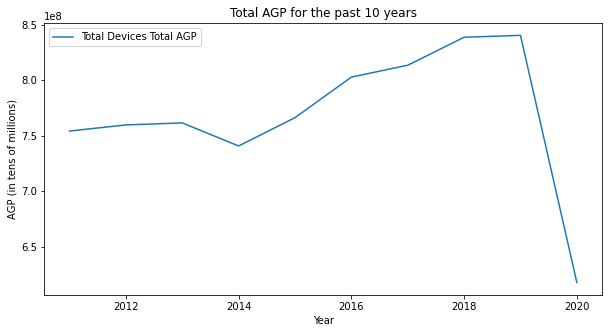

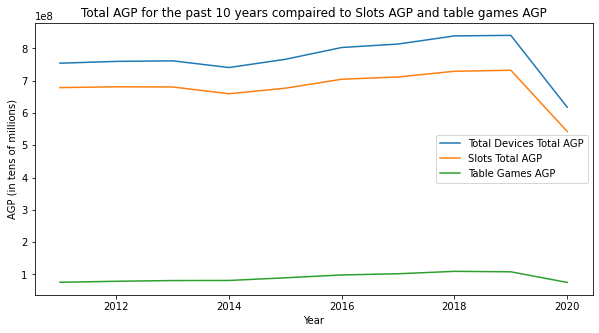

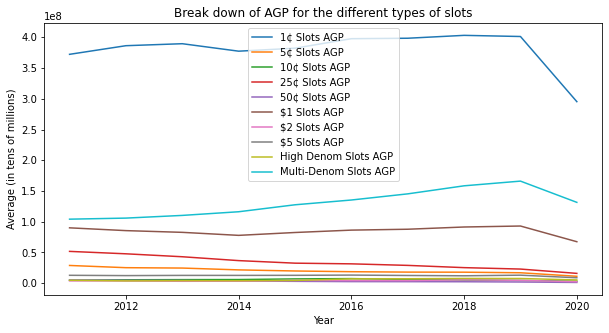

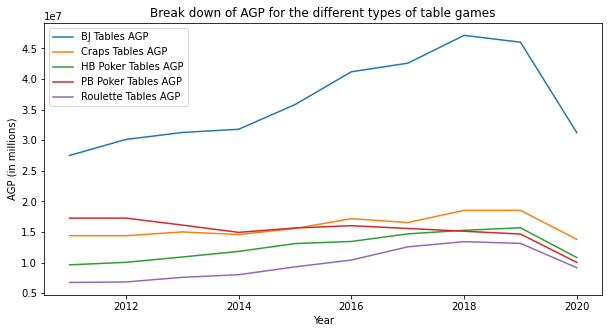

<Figure size 720x360 with 0 Axes>

In [5]:
#plot 1



state_total= state.loc[(state['month'].isin(['TOTAL']))]
state_total.loc[:,'year'] = state_total.loc[:,'year'].astype(int)
state_total=state_total.loc[(state_total['year'] < 2021)]
print(state_totals.head(20))

ax = plt.gca()
state_total.plot(kind='line',x='year',y='Total Devices Total AGP',ax=ax)


plt.title("Total AGP for the past 10 years")
plt.xlabel("Year")
plt.ylabel("AGP (in tens of millions)")
plt.show()
plt.savefig('Plot1.png')


#plot 2
ax = plt.gca()

state_total.plot(kind='line',x='year',y='Total Devices Total AGP',ax=ax)
state_total.plot(kind='line',x='year',y='Slots Total AGP',ax=ax)
state_total.plot(kind='line',x='year',y='Table Games AGP',ax=ax)



plt.title("Total AGP for the past 10 years compaired to Slots AGP and table games AGP")
plt.xlabel("Year")
plt.ylabel("AGP (in tens of millions)")
plt.show()
plt.savefig('Plot2.png')
#pie plot




#plot 3
ax = plt.gca()

state_total.plot(kind='line',x='year',y='1¢ Slots AGP',ax=ax)
state_total.plot(kind='line',x='year',y='5¢ Slots AGP',ax=ax)
state_total.plot(kind='line',x='year',y='10¢ Slots AGP',ax=ax)
state_total.plot(kind='line',x='year',y='25¢ Slots AGP',ax=ax)
state_total.plot(kind='line',x='year',y='50¢ Slots AGP',ax=ax)
state_total.plot(kind='line',x='year',y='$1 Slots AGP',ax=ax)
state_total.plot(kind='line',x='year',y='$2 Slots AGP',ax=ax)
state_total.plot(kind='line',x='year',y='$5 Slots AGP',ax=ax)
state_total.plot(kind='line',x='year',y='High Denom Slots AGP',ax=ax)
state_total.plot(kind='line',x='year',y='Multi-Denom Slots AGP',ax=ax)
#state.plot(kind='line',x='name',y='num_pets', color='red', ax=ax)

plt.title("Break down of AGP for the different types of slots")
plt.xlabel("Year")
plt.ylabel("Average (in tens of millions)")
plt.show()
plt.savefig('Plot3.png')
#plot 4
ax = plt.gca()

state_total.plot(kind='line',x='year',y='BJ Tables AGP',ax=ax)
state_total.plot(kind='line',x='year',y='Craps Tables AGP',ax=ax)
state_total.plot(kind='line',x='year',y='HB Poker Tables AGP',ax=ax)
state_total.plot(kind='line',x='year',y='PB Poker Tables AGP',ax=ax)
state_total.plot(kind='line',x='year',y='Roulette Tables AGP',ax=ax)
#state.plot(kind='line',x='name',y='num_pets', color='red', ax=ax)

plt.title("Break down of AGP for the different types of table games")
plt.xlabel("Year")
plt.ylabel("AGP (in millions)")
plt.show()
plt.savefig('Plot 4.png')


In [40]:
gamedf_T_mod = gamedf_T.dropna(axis=0)

winfilt = (gamedf_T_mod.loc[:,'season'] == 'WINTER')
gamedf_T_mod.loc[winfilt,'season'] = 0
winfilt = (gamedf_T_mod['season'] == 'SPRING')
gamedf_T_mod.loc[winfilt,'season'] = 1
winfilt = (gamedf_T_mod['season'] == 'SUMMER')
gamedf_T_mod.loc[winfilt,'season'] = 2
winfilt = (gamedf_T_mod['season'] == 'AUTUMN')
gamedf_T_mod.loc[winfilt,'season'] = 3



slotscoinsin = gamedf_T_mod.loc[:,'Slots Total Coins In'].to_numpy().flatten(order='F')
slotsagp = gamedf_T_mod.loc[:,'Slots Total AGP'].to_numpy().flatten(order='F')
slotshold = gamedf_T_mod.loc[:,'Slots Total Hold %'].to_numpy().flatten(order='F')
slotsseason = gamedf_T_mod.loc[:,'season'].to_numpy().flatten(order='F')
# 'Slots Total Hold %'
slotsseason = np.c_[ slotsseason, slotsseason, slotsseason, slotsseason ].flatten(order='F')
slotsseason = to_categorical(slotsseason, num_classes = 4)

xdata = np.c_[slotscoinsin, slotsagp, slotshold]
xdata = xdata / xdata.max(axis=0)

x_train, x_test, y_train, y_test = train_test_split(xdata, slotsseason, test_size=1/10, random_state=101, shuffle=True)
y_train = np.asarray(y_train, dtype= np.int64)
y_test = np.asarray(y_test, dtype= np.int64)
x_train = np.asarray(x_train, dtype= np.float64)
x_test = np.asarray(x_test, dtype= np.float64)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(32, input_shape=(3,),activation="relu"))
model.add(tf.keras.layers.Dense(32,activation="relu"))
model.add(tf.keras.layers.Dense(4,activation="softmax"))

model.compile(optimizer=keras.optimizers.Adam(learning_rate = 1/10000), \
              loss=keras.losses.CategoricalCrossentropy(), \
              metrics=[keras.metrics.CategoricalAccuracy()],)
numepochs = 100
seasmodmetrics = model.fit(x = x_train, y = y_train, validation_data=(x_test, y_test), batch_size = 10, epochs = numepochs, shuffle = True, verbose = 2)


/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


0     False
1     False
2      True
3      True
4      True
5     False
6     False
7     False
8     False
9     False
10    False
11    False
13    False
14    False
15     True
16     True
17     True
18    False
19    False
20    False
Name: season, dtype: bool
Epoch 1/100
44/44 - 1s - loss: 1.4031 - categorical_accuracy: 0.2407 - val_loss: 1.3968 - val_categorical_accuracy: 0.2917
Epoch 2/100
44/44 - 0s - loss: 1.3995 - categorical_accuracy: 0.2407 - val_loss: 1.3944 - val_categorical_accuracy: 0.2917
Epoch 3/100
44/44 - 0s - loss: 1.3969 - categorical_accuracy: 0.2407 - val_loss: 1.3931 - val_categorical_accuracy: 0.2917
Epoch 4/100
44/44 - 0s - loss: 1.3944 - categorical_accuracy: 0.2407 - val_loss: 1.3913 - val_categorical_accuracy: 0.2917
Epoch 5/100
44/44 - 0s - loss: 1.3926 - categorical_accuracy: 0.2384 - val_loss: 1.3903 - val_categorical_accuracy: 0.2917
Epoch 6/100
44/44 - 0s - loss: 1.3913 - categorical_accuracy: 0.2338 - val_loss: 1.3895 - val_categorical_accuracy: 0.2

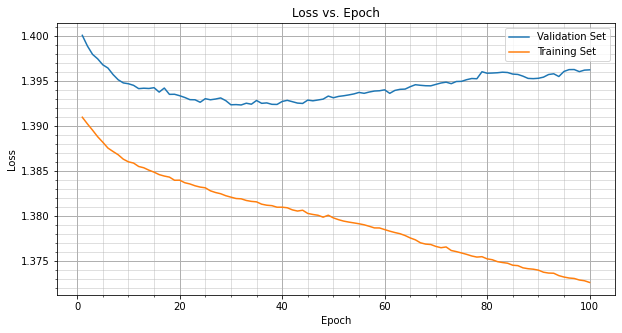

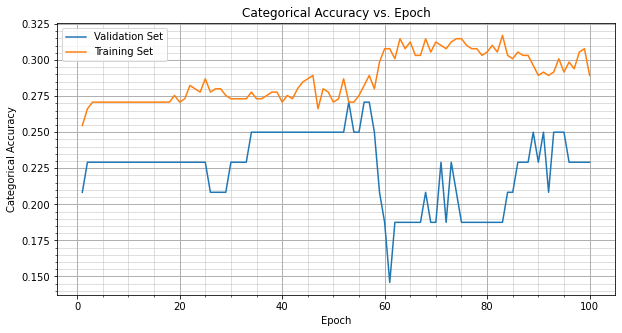

In [12]:
epochvals = np.arange(1,numepochs + 1)
plt.figure(0)
plt.minorticks_on()
plt.grid(which='minor', alpha=0.5)
plt.grid(which='major', linewidth=1)
plt.plot(epochvals, seasmodmetrics.history['val_loss'])
plt.plot(epochvals, seasmodmetrics.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Validation Set','Training Set'])
plt.title('Loss vs. Epoch')
plt.savefig('seas-neuralnet_loss')

plt.figure(1)
plt.minorticks_on()
plt.grid(which='minor', alpha=0.5)
plt.grid(which='major', linewidth=1)
plt.plot(epochvals,seasmodmetrics.history['val_categorical_accuracy'])
plt.plot(epochvals,seasmodmetrics.history['categorical_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Categorical Accuracy')
plt.legend(['Validation Set','Training Set'])
plt.title('Categorical Accuracy vs. Epoch')
plt.savefig('seas-neuralnet_acc')

In [8]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(32, input_shape=(3,),activation="relu"))
model.add(tf.keras.layers.Dense(32,activation="relu"))
model.add(tf.keras.layers.Dense(4,activation="softmax"))

model.compile(optimizer=keras.optimizers.Adam(learning_rate = 1/10000), \
              loss=keras.losses.CategoricalCrossentropy(), \
              metrics=[keras.metrics.CategoricalAccuracy()],)

xlist = [state.loc[:,'Slots Total Coins In'].tolist() + \
                       cripple.loc[:,'Slots Total Coins In'].tolist() + \
                        black.loc[:,'Slots Total Coins In'].tolist() + \
                       central.loc[:,'Slots Total Coins In'].tolist(), \
         state.loc[:,'Slots Total AGP'].tolist() + \
         cripple.loc[:,'Slots Total AGP'].tolist() + \
         black.loc[:,'Slots Total AGP'].tolist() + \
         central.loc[:,'Slots Total AGP'].tolist(), \
        state.loc[:,'Slots Total Hold %'].tolist() + \
         cripple.loc[:,'Slots Total Hold %'].tolist() + \
         black.loc[:,'Slots Total Hold %'].tolist() + \
         central.loc[:,'Slots Total Hold %'].tolist()]
xdata = np.asarray(xlist).T

xdata = xdata / xdata.max(axis=0) # Normalized the data
rowlen = int(len(xdata) / 4)


arr1 = np.full(shape=rowlen, fill_value=0, dtype=np.int64)
arr2 = np.full(shape=rowlen, fill_value=1, dtype=np.int64)
arr3 = np.full(shape=rowlen, fill_value=2, dtype=np.int64)
arr4 = np.full(shape=rowlen, fill_value=3, dtype=np.int64)

ydata = np.concatenate((arr1,arr2,arr3,arr4), axis=None)
ydata = to_categorical(ydata, num_classes = 4)
x_train, x_test, y_train, y_test = train_test_split(xdata, ydata, test_size=1/10, random_state=101, shuffle=True)

numepochs = 100
modmetrics = model.fit(x = x_train, y = y_train, validation_data=(x_test, y_test), batch_size = 10, epochs = numepochs, shuffle = True, verbose = 2)

Epoch 1/100
47/47 - 1s - loss: 1.3904 - categorical_accuracy: 0.2650 - val_loss: 1.3966 - val_categorical_accuracy: 0.1346
Epoch 2/100
47/47 - 0s - loss: 1.3886 - categorical_accuracy: 0.2628 - val_loss: 1.3956 - val_categorical_accuracy: 0.1346
Epoch 3/100
47/47 - 0s - loss: 1.3869 - categorical_accuracy: 0.2628 - val_loss: 1.3941 - val_categorical_accuracy: 0.1346
Epoch 4/100
47/47 - 0s - loss: 1.3855 - categorical_accuracy: 0.2628 - val_loss: 1.3930 - val_categorical_accuracy: 0.1346
Epoch 5/100
47/47 - 0s - loss: 1.3846 - categorical_accuracy: 0.2628 - val_loss: 1.3914 - val_categorical_accuracy: 0.1346
Epoch 6/100
47/47 - 0s - loss: 1.3837 - categorical_accuracy: 0.2628 - val_loss: 1.3900 - val_categorical_accuracy: 0.1346
Epoch 7/100
47/47 - 0s - loss: 1.3829 - categorical_accuracy: 0.2628 - val_loss: 1.3890 - val_categorical_accuracy: 0.1346
Epoch 8/100
47/47 - 0s - loss: 1.3822 - categorical_accuracy: 0.2756 - val_loss: 1.3876 - val_categorical_accuracy: 0.2115
Epoch 9/100
47/4

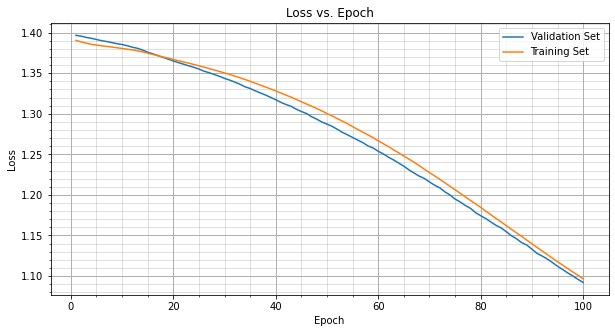

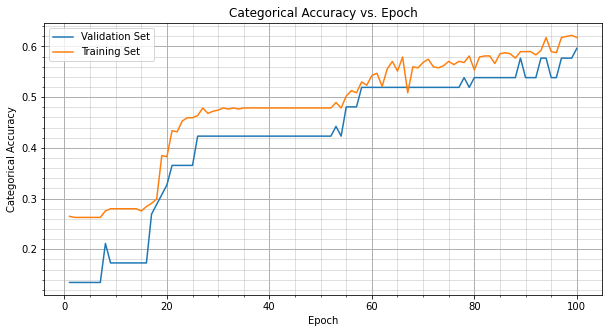

In [9]:
epochvals = np.arange(1,numepochs + 1)
plt.figure(0)
plt.minorticks_on()
plt.grid(which='minor', alpha=0.5)
plt.grid(which='major', linewidth=1)
plt.plot(epochvals, modmetrics.history['val_loss'])
plt.plot(epochvals, modmetrics.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Validation Set','Training Set'])
plt.title('Loss vs. Epoch')
plt.savefig('neuralnet_loss')

plt.figure(1)
plt.minorticks_on()
plt.grid(which='minor', alpha=0.5)
plt.grid(which='major', linewidth=1)
plt.plot(epochvals,modmetrics.history['val_categorical_accuracy'])
plt.plot(epochvals,modmetrics.history['categorical_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Categorical Accuracy')
plt.legend(['Validation Set','Training Set'])
plt.title('Categorical Accuracy vs. Epoch')
plt.savefig('neuralnet_acc')

Attributes           index Slots Total Slots Total Coins In Slots Total AGP  \
110           JANUARY 2019       12589         749180736.04     54815981.51   
111          FEBRUARY 2019       12512          734327482.9     54751308.77   
112             MARCH 2019       12463         849313975.54     63587102.13   
113             APRIL 2019       12313         791125385.82     58623825.32   
114               MAY 2019       12334         858492590.13     64739958.65   
115              JUNE 2019       12298         843384484.32     63395321.98   
116             TOTAL 2019      150615        9872427467.66    732246423.09   
117              JULY 2019       12541         884257054.33     65994302.91   
118            AUGUST 2019       12533         878688046.01     66655482.77   
119         SEPTEMBER 2019       12519          844863925.8     62989467.67   
120           OCTOBER 2019       12487         751309493.78     56264250.17   
121          NOVEMBER 2019       12483         77074

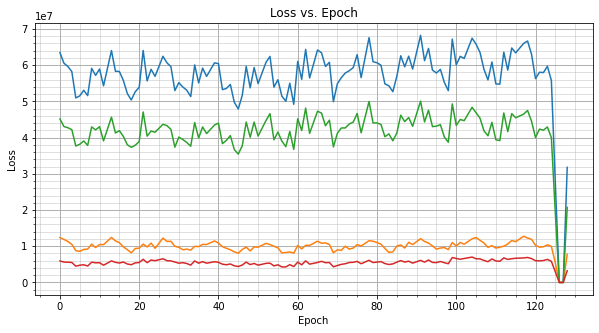

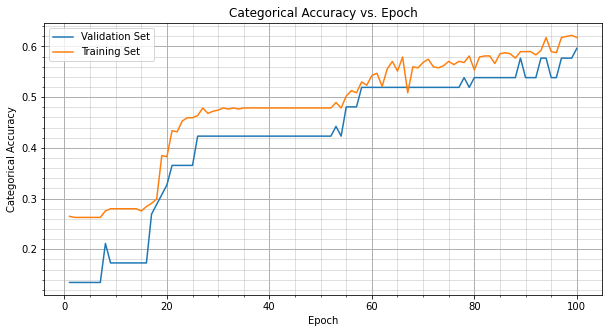

In [23]:
print(gamedf_T.tail(20))

plt.figure(0)
plt.minorticks_on()
plt.grid(which='minor', alpha=0.5)
plt.grid(which='major', linewidth=1)
plt.plot(gamedf_T_mod['Slots Total AGP'])

plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.title('Loss vs. Epoch')


plt.figure(1)
plt.minorticks_on()
plt.grid(which='minor', alpha=0.5)
plt.grid(which='major', linewidth=1)
plt.plot(epochvals,modmetrics.history['val_categorical_accuracy'])
plt.plot(epochvals,modmetrics.history['categorical_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Categorical Accuracy')
plt.legend(['Validation Set','Training Set'])
plt.title('Categorical Accuracy vs. Epoch')
plt.savefig('neuralnet_acc')



54241690.602
61103879.675
[66175508.21800001, 58391299.796000004, 62437215.66400001, 61850094.47800001, 72564915.35500002, 69913377.28500001, 67275419.086, 64592279.285000004, 61529880.907000005, 54241690.602, 61694620.507999994, 61103879.675]


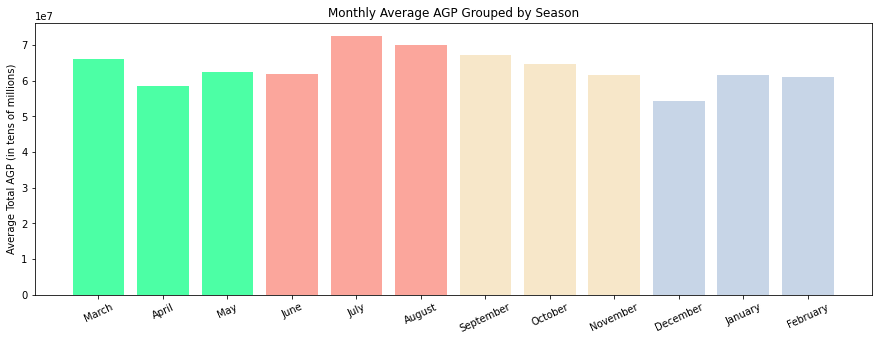

In [136]:

seaave=state_totals.dropna(axis=0)


nov=seaave[seaave['month'].str.contains('NOV')]
#seaave=seaave[:,'Slots Total AGP'].to_numpy().flatten(order='F')
dec=seaave[seaave['month'].str.contains('DEC')]
jan=seaave[seaave['month'].str.contains('JANUARY')]
feb=seaave[seaave['month'].str.contains('FEB')]
mar=seaave[seaave['month'].str.contains('MARCH')]
apr=seaave[seaave['month'].str.contains('APRI')]
may=seaave[seaave['month'].str.contains('MAY')]
jun=seaave[seaave['month'].str.contains('JUNE')]
jul=seaave[seaave['month'].str.contains('JULY')]
aug=seaave[seaave['month'].str.contains('AUGUST')]
sep=seaave[seaave['month'].str.contains('SEPT')]
octo=seaave[seaave['month'].str.contains('OCTO')]
decave=dec['Slots Total AGP'].mean()

janave=jan['Total Devices Total AGP'].mean()
febave=feb['Total Devices Total AGP'].mean()
marave=mar['Total Devices Total AGP'].mean()
aprave=apr['Total Devices Total AGP'].mean()
mayave=may['Total Devices Total AGP'].mean()
junave=jun['Total Devices Total AGP'].mean()
julave=jul['Total Devices Total AGP'].mean()
augave=aug['Total Devices Total AGP'].mean()
sepave=sep['Total Devices Total AGP'].mean()
octoave=octo['Total Devices Total AGP'].mean()
novave=nov['Total Devices Total AGP'].mean()
print(decave)
print(febave)

df2=[marave,aprave,mayave,junave,julave,augave,sepave,octoave,novave,decave,janave,febave]
print(df2)
objects = ('February', "January", "December" ,"November", "October","September",'August', 'July', 'June', 'May', 'April', 'March' )
objects = ('March', "April", "May" ,"June", "July","August",'September', 'October', 'November', 'December', 'January', 'February' )
y_pos = np.arange(len(objects))
performance = df2

plt.bar(y_pos, performance, align='center', alpha=0.7, color=['springgreen', 'springgreen', 'springgreen','salmon','salmon','salmon','wheat', 'wheat','wheat','lightsteelblue', 'lightsteelblue', 'lightsteelblue'])
plt.xticks(y_pos, objects, rotation=25)
plt.ylabel('Average Total AGP (in tens of millions)')
plt.title('Monthly Average AGP Grouped by Season')
plt.savefig('barchart.png')
plt.show()



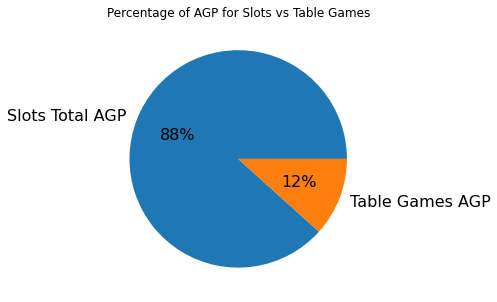

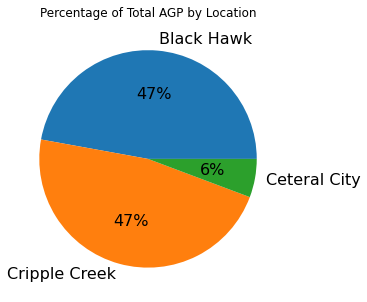

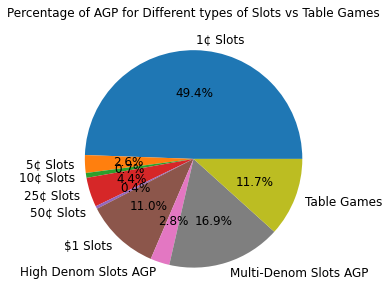

In [133]:
import random

slotave=state_totals["Slots Total AGP"].mean()
tableave=state_totals["Table Games AGP"].mean()
df3=[slotave,tableave]
mylabels = ["Slots Total AGP", "Table Games AGP"]

plt.pie(df3, labels = mylabels,autopct='%1.0f%%',textprops={'fontsize': 16})
plt.title("Percentage of AGP for Slots vs Table Games")
plt.savefig('piechart2.png')
plt.show() 
plt.savefig('barchart.png')
blackhawkave=black_totals['Total Devices Total AGP'].mean()
crippleave=black_totals['Total Devices Total AGP'].mean()
centeralave=central_totals['Total Devices Total AGP'].mean()
mylabels2 = ["Black Hawk", "Cripple Creek", "Ceteral City"]
df4=[blackhawkave,crippleave,centeralave]
plt.pie(df4,labels=mylabels2,autopct='%1.0f%%',textprops={'fontsize': 16})
plt.title("Percentage of Total AGP by Location")
plt.savefig('piechart1.png')
plt.show()

mylables3=['1¢ Slots','5¢ Slots','10¢ Slots','25¢ Slots','50¢ Slots','$1 Slots','High Denom Slots AGP','Multi-Denom Slots AGP','Table Games']
one=state_totals["1¢ Slots AGP"].mean()
five=state_totals["5¢ Slots AGP"].mean()
ten=state_totals["10¢ Slots AGP"].mean()
twentyfive=state_totals["25¢ Slots AGP"].mean()
fifty=state_totals["50¢ Slots AGP"].mean()
dollar=state_totals["$1 Slots AGP"].mean()
two=state_totals["$2 Slots AGP"].mean()
fived=state_totals["$5 Slots AGP"].mean()+state_totals["High Denom Slots AGP"].mean()+state_totals["$2 Slots AGP"].mean()
high=state_totals["High Denom Slots AGP"].mean()
multi=state_totals["Multi-Denom Slots AGP"].mean()
df5=[one,five,ten,twentyfive,fifty,dollar,fived,multi,tableave]
fived2=state_totals["$5 Slots AGP"].mean()

plt.pie(df5,labels=mylables3,autopct='%1.01f%%',textprops={'fontsize': 12})
plt.title("Percentage of AGP for Different types of Slots vs Table Games")
plt.savefig('piechart3.png')
plt.show()


